<a href="https://colab.research.google.com/github/rachel1818/Recommender/blob/main/Movie_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTING OF LIBRARIES**

In [ ]:
%pip install surprise
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import LeaveOneOut
from surprise import Reader, Dataset, SVD, NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, BaselineOnly, SVDpp, NMF, SlopeOne, CoClustering
from surprise import accuracy
from collections import defaultdict
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans
from scipy import sparse
from scipy.sparse import csr_matrix as csr
import warnings; warnings.simplefilter('ignore')
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

***PREVIEWING OF THE DATASET***

In [ ]:
movies = pd.read_csv('movies_metadata.csv')
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
ratings_n = pd.read_csv('ratings_small.csv')

In [ ]:
ratings_n.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


***PROCESSING*** 

***USING literal_eval TO SAFELY EVALUATE STRINGS IN THE GENRE COLUMN***

In [ ]:
movies['genres'] = movies['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [ ]:
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [ ]:
movies.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,year
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


***READING THE LINKS FILE***

In [ ]:
links_small = pd.read_csv('links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')
links_small.head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: tmdbId, dtype: int64

***DROPPED ROWS WHICH WEREN'T USEFUL TO THE DATA PROCESSING***

In [ ]:
movies = movies.drop([19730, 29503, 35587])

In [ ]:
movies['id'] = movies['id'].astype('int')

***SELECTING THE MOVIES WHICH ARE PRESENT IN THE LINKS_SMALL FILE***

In [ ]:
movies_links = movies[movies['id'].isin(links_small)]
movies_links.shape

(9099, 25)

In [ ]:
movies_links["movieId"] = movies_links["id"]

### ***MOVIE RECOMMENDATION USING CLUSTERRING ALGORITHM (KNN)***

***MERGING THE RATING AND MOVIES TABLE***

In [ ]:
ratings_title = pd.merge(ratings_n, movies_links[['movieId', 'original_title']], on='movieId' )
user_movie_ratings = pd.pivot_table(ratings_title, index='userId', columns= 'original_title', values='rating')

In [ ]:
# Dispaying the dimensions of the dataset and a subset of the dataset
print('dataset dimensions: ', user_movie_ratings.shape, '\n\nSubset example:')
user_movie_ratings.iloc[:6, :10]

dataset dimensions:  (671, 1536) 

Subset example:


original_title,10 Items or Less,10 Things I Hate About You,"10,000 BC",11'09''01 - September 11,12 Angry Men,13 Tzameti,1408,15 Minutes,16 Blocks,1984
userId,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


***SORTING THE DATASET BY MOST RATED MOVIES***

In [ ]:
# Function to get the most rated movies
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

***REPRESENTATION USING HEAT-MAP***

In [ ]:
# Function for plotting heat-map
def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')
    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.grid(False)
        ax.set_ylabel('User id')
# Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
# Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])
    plt.show()

***CONVERTING THE SPARSE DATASET INTO A DENSE FORM TO USE IT FOR KNN***

In [ ]:
#To improve the performance of the model, using only use ratings for 1000 movies
# Pivoting the dataset and choosing the first 1000 movies
user_movie_ratings =  pd.pivot_table(ratings_title, index='userId', columns= 'original_title', values='rating')
most_rated_movies_1k = get_most_rated_movies(user_movie_ratings, 1000)
most_rated_movies_1k.head()

original_title,Terminator 3: Rise of the Machines,The Million Dollar Hotel,Солярис,The 39 Steps,Monsoon Wedding,Once Were Warriors,Trois couleurs : Rouge,Men in Black II,La passion de Jeanne d'Arc,Silent Hill,License to Wed,The Hours,Sleepless in Seattle,48 Hrs.,Batman Returns,Rain Man,The Conversation,Say Anything...,Rope,A Nightmare on Elm Street,To Kill a Mockingbird,La belle et la bête,Bridge to Terabithia,Dawn of the Dead,Syriana,Reservoir Dogs,Arlington Road,Titanic,The Man with the Golden Arm,Halbe Treppe,Back to the Future Part II,The Thomas Crown Affair,Mosura tai Gojira,Shriek If You Know What I Did Last Friday the Thirteenth,Point Break,A River Runs Through It,The Talented Mr. Ripley,And Then There Were None,Wag the Dog,Lost in Translation,...,Gazon maudit,A Chorus Line,The Last Mimzy,Heavenly Creatures,City Slickers,A Christmas Story,The Bodyguard,A Few Good Men,Mujeres al borde de un ataque de nervios,Wild at Heart,Der Tunnel,Die Hard: With a Vengeance,Star Trek: First Contact,The X Files,Three of Hearts,Teenage Mutant Ninja Turtles II: The Secret of the Ooze,Shall We Dance?,American Pie Presents: The Naked Mile,Soldaat van Oranje,Sin City,Shane,Dark Blue,Star Trek: The Motion Picture,Taxi,Deep Impact,To End All Wars,Angel Baby,Treasure Island,Code 46,The Wild Angels,Shine a Light,Swimming to Cambodia,Chocolat,The X Files: I Want to Believe,The Astronaut's Wife,Desert Hearts,The Assassination of Richard Nixon,The Bounty,Das Boot,Ronin
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4.0,NaN,3.0,NaN,4.0,4.0,4.0,NaN,NaN,3.0,NaN,5.0,NaN,5.0,3.0,NaN,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.5,5.0,3.0,NaN,NaN,3.0,4.0,NaN,NaN,3.0,5.0,NaN,NaN,NaN,NaN,NaN,3.0,4.0,3.5,2.5,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.0,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,NaN,5.0,3.0,NaN,NaN,5.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,5.0,NaN,5.0,NaN,NaN,5.0,NaN,NaN,5.0,NaN,5.0,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,2.5,4.0,4.0,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,3.5,4.5,NaN,5.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Sparse datset conversion
df = most_rated_movies_1k.astype(pd.SparseDtype("float",np.nan))
X = df.sparse.to_coo()

***USING KNN TO FORM CLUSTERS***

In [ ]:
# 20 clusters
predictions = KMeans(n_clusters=20, algorithm='full').fit_predict(X)
# Select the mas number of users and movies heatmap cluster
max_users = 70
max_movies = 50
# Cluster and print some of them
clustered = pd.concat([most_rated_movies_1k.reset_index(), pd.DataFrame({'group':predictions})], axis=1)


***VISUALIZING THE CLUSTERS FORMED***

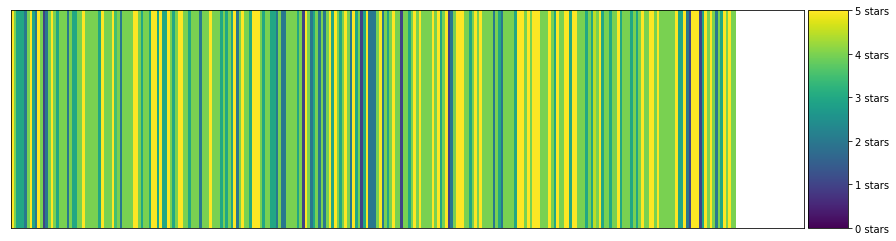

In [ ]:
# Picking a cluster ID from the clusters above
cluster_number = 11
# Let's filter to only see the region of the dataset with the most number of values 
n_users = 75
n_movies = 300
cluster = clustered[clustered.group == cluster_number].drop(['index', 'group'], axis=1)
# Sort and print the cluster
cluster = get_most_rated_movies(cluster, n_movies)
draw_movies_heatmap(cluster, axis_labels=False)

In [ ]:
# Print the ratings
cluster.fillna('').head()

,Terminator 3: Rise of the Machines,Caché,Evil Dead II,One Night at McCool's,Sophie Scholl – Die letzten Tage,The Believer,Eastern Promises,Beyond Rangoon,28 Weeks Later,American Pie,Rocky,Million Dollar Baby,Two Weeks Notice,A Close Shave,The Thin Man,Meet the Robinsons,La Pianiste,Hostel,The Ladykillers,Hitman,A Bridge Too Far,Duck Soup,Killing Zoe,My Tutor,Little Children,While You Were Sleeping,Enough,Flags of Our Fathers,An Unfinished Life,Ice Age,Leaving Las Vegas,88 Minutes,The Chronicles of Narnia: Prince Caspian,Double Indemnity,Cold Mountain,Final Fantasy: The Spirits Within,The Shipping News,24 Hour Party People,Rosemary's Baby,De jurk,...,Mr. Holland's Opus,Hairspray,Love Actually,リング,Married to the Mob,Star Wars,Blade Runner,Un long dimanche de fiançailles,The Great Outdoors,Deux frères,Stand by Me,Notting Hill,M,The Good Shepherd,Transformers,Munich,Night at the Museum,A Hard Day's Night,纵横四海,Bill & Ted's Bogus Journey,Z,Ночной дозор,Primal Fear,Pulp Fiction,Dune,Angel Heart,An American in Paris,Pirates of the Caribbean: On Stranger Tides,The Lord of the Rings,Snakes on a Plane,Indecent Proposal,Exodus,Bird on a Wire,Swimming Pool,The Lovely Bones,The Interpreter,Tropa de Elite,Riding Giants,Jurassic Park III,Fire
0,5.0,4.0,3.0,3.0,3.0,2.0,4.0,5.0,3.0,2.0,5.0,4.0,1.0,2.0,4.0,5.0,4.0,3.0,4.0,4.0,4.0,2.0,4.0,3.0,3.0,4.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,3.0,5.0,4.0,4.0,4.0,5.0,3.5,...,1.0,3.0,5.0,4.0,5.0,4.0,2.0,4.0,3.0,5.0,4.0,5.0,4.0,4.0,,,,,,,,,,,,,,,,,,,,,,,,,,


***PREDICTING RATING USING CLUSTERING***

In [ ]:
# Fill in the name of the column/movie. e.g. 'Star Wars'
movie_name = 'Star Wars'
cluster[movie_name].mean()

4.0

In [ ]:
# The average rating of 20 movies as rated by the users in the cluster
cluster.mean().head(20)

Terminator 3: Rise of the Machines    5.0
Caché                                 4.0
Evil Dead II                          3.0
One Night at McCool's                 3.0
Sophie Scholl – Die letzten Tage      3.0
The Believer                          2.0
Eastern Promises                      4.0
Beyond Rangoon                        5.0
28 Weeks Later                        3.0
American Pie                          2.0
Rocky                                 5.0
Million Dollar Baby                   4.0
Two Weeks Notice                      1.0
A Close Shave                         2.0
The Thin Man                          4.0
Meet the Robinsons                    5.0
La Pianiste                           4.0
Hostel                                3.0
The Ladykillers                       4.0
Hitman                                4.0
dtype: float64

***RECOMMENDATION USING CLUSTERING (KNN)***

In [ ]:
# Pick a user ID from the dataset
user_id = 1
# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]
# Which movies did they not rate? 
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]
# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]
# Let's sort by rating so the highest rated movies are presented first
avg_ratings.sort_values(ascending=False)[:20]

KeyError: ignored

**END OF MOVIE RECOMMENDATION USING CLUSTERING ALGORITHM (KNN) **

## **VISUALIZATION OF THE DATASET**

In [ ]:
movies_links['popularity'] = movies_links['popularity'].astype('float')

In [ ]:
pop= movies_links.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

In [ ]:
s = movies.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = movies.drop('genres', axis=1).join(s)

In [ ]:
md_year = pd.DataFrame(gen_md.groupby('release_date').original_title.nunique())
md_year.head()

In [ ]:
md_year.nlargest(5,'original_title')

In [ ]:
md_year.plot.line(title = 'Movies made per year',color='DarkBlue',figsize=(10, 8));

In [ ]:
md_genre = (pd.DataFrame(gen_md.groupby('genre').original_title.nunique())).sort_values('original_title', ascending=True)
md_genre.head(20)

In [ ]:
md_genre['original_title'].plot.pie(title= 'Movies per Genre in %', figsize=(15,15), autopct='%1.1f%%',fontsize=15);

In [ ]:
md_year_mean = gen_md.groupby('release_date').mean()
md_year_mean.head(3)

In [ ]:
md_year_mean.nlargest(5,'vote_count')

In [ ]:
md_year_mean[['vote_average', 'vote_count']].plot(title = 'TBD',color=('DarkBlue','c'),figsize=(15, 10),secondary_y=['vote_average']);

In [ ]:
movies.corr(method='pearson')

In [ ]:
movies.plot.scatter(x='vote_average', y='revenue',title='Revenue vs Vote Avg',color='DarkBlue',figsize=(6,5));

### **CONTENT RECOMMENDER 1**

In [ ]:
movies_links.head()

In [ ]:
movies_links['tagline'] = movies_links['tagline'].fillna('')
movies_links['description'] = movies_links['overview'] + movies_links['tagline']
movies_links['description'] = movies_links['description'].fillna('')

In [ ]:
movies_links['description']

In [ ]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_links['description'])

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix)

In [ ]:
cosine_sim

In [ ]:
movies_links.head()

In [ ]:
movies_links = movies_links.reset_index()
titles = movies_links['title']
indices = pd.Series(movies_links.index, index=movies_links['title'])

In [ ]:
titles

In [ ]:
def content_recommendations1(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores,key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [ ]:
content_recommendations1('Summer of Sam').head(10)

In [ ]:
content_recommendations1('Batman: Under the Red Hood').head(10)

### ***CONTENT RECOMMENDER 2***

In [ ]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')

In [ ]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movies['id'] = movies['id'].astype('int')

In [ ]:
movies.shape

In [ ]:
movies = movies.merge(credits, on='id')
movies = movies.merge(keywords, on='id')

In [ ]:
movies_links = movies[movies['id'].isin(links_small)]
movies_links.shape

In [ ]:
movies_links['cast'] = movies_links['cast'].apply(literal_eval)
movies_links['crew'] = movies_links['crew'].apply(literal_eval)
movies_links['keywords'] = movies_links['keywords'].apply(literal_eval)
movies_links['cast_size'] = movies_links['cast'].apply(lambda x: len(x))
movies_links['crew_size'] = movies_links['crew'].apply(lambda x: len(x))

In [ ]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
movies_links['director'] = movies_links['crew'].apply(get_director)

In [ ]:
movies_links['cast'] = movies_links['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_links['cast'] = movies_links['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [ ]:
movies_links['keywords'] = movies_links['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [ ]:
movies_links['cast'] = movies_links['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
movies_links['director'] = movies_links['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
movies_links['director'] = movies_links['director'].apply(lambda x: [x,x, x])

In [ ]:
movies_links.head(1)

In [ ]:
s = movies_links.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'

In [ ]:
s = s.value_counts()
sd = pd.DataFrame(s)

In [ ]:
sd.head(10)

In [ ]:
s = s[s > 1]

In [ ]:
lemman = WordNetLemmatizer()

In [ ]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [ ]:
movies_links['keywords'] = movies_links['keywords'].apply(filter_keywords)
movies_links['keywords'] = movies_links['keywords'].apply(lambda x: [lemman.lemmatize(i) for i in x])
movies_links['keywords'] = movies_links['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

In [ ]:
movies_links['combo'] = movies_links['keywords'] + movies_links['cast'] + movies_links['director'] + movies_links['genres']
movies_links['combo'] = movies_links['combo'].apply(lambda x: ' '.join(x))

In [ ]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
bow = count.fit_transform(movies_links['combo'])

In [ ]:
cosine_sim = cosine_similarity(bow)

In [ ]:
movies_links = movies_links.reset_index()
titles = movies_links['title']
indices = pd.Series(movies_links.index, index=movies_links['title'])

In [ ]:
def content_recommendations2(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movie = movies_links.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movie[movie['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movie[movie['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    def weighted_rating(x):
        v = x['vote_count']
        R = x['vote_average']
        return (v/(v+m) * R) + (m/(m+v) * C)
    qualified = movie[(movie['vote_count'] >= m) & (movie['vote_count'].notnull()) & (movie['vote_average'].notnull())]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    qualified['wr'] = qualified.apply(weighted_rating, axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(10)
    return qualified

In [ ]:
content_recommendations2('Inception')

In [ ]:
content_recommendations2('Mean Girls')

### ***COLABORATIVE FILTERING***

In [ ]:
reader = Reader()

In [ ]:
ratings = pd.read_csv('ratings_small.csv')
ratings

In [ ]:
gb = ratings.groupby(['userId','movieId'])
gb.apply(lambda _df: _df.sort_values(by=['rating']))

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

***CROSS-VALIDATION***

In [ ]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE','MAE'], cv=10, verbose=True)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

In [ ]:
bench=pd.DataFrame(benchmark).sort_values('test_rmse')

In [ ]:
sns.barplot(x='Algorithm',y='test_rmse',data=bench,label="Number of Words")
plt.xticks(rotation=90)
plt.show()

In [ ]:
trainset = data.build_full_trainset()

svd = SVD()
svd.fit(trainset)

In [ ]:
svd.predict(1, 302, 3)

### ***HYBRID***

In [ ]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [ ]:
id_map = pd.read_csv('links_small.csv')[['movieId', 'tmdbId']]
id_map['tmdbId'] = id_map['tmdbId'].apply(convert_int)
id_map.columns = ['movieId', 'id']
id_map = id_map.merge(movies_links[['title', 'id']], on='id').set_index('title')

In [ ]:
indices_map = id_map.set_index('id')

***HYBRID FUNCTION***

In [ ]:
def hybrid(userId, title):
    idx = indices[title]
    tmdbId = id_map.loc[title]['id']
    
    movie_id = id_map.loc[title]['movieId']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:26]
    movie_indices = [i[0] for i in sim_scores]
    
    movies = movies_links.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year', 'id']]
    movies['est'] = movies['id'].apply(lambda x: svd.predict(userId, indices_map.loc[x]['movieId']).est)
    movies = movies.sort_values('est', ascending=False)
    return movies.head(10)

In [ ]:
hybrid(1, 'Avatar')

In [ ]:
hybrid(500, 'Avatar')

In [ ]:
hybrid(500, 'Aliens')

In [ ]:
hybrid(1, 'Aliens')

## ***EVALUATION - HIT RATE***

***INITIALIZING LEAVEONEOUT FUNCTION***

In [ ]:
LOOCV = LeaveOneOut(n_splits=1, random_state=1)

***DEFINING A FUNCTION TO GET THE TOP TEN PREDICTIONS FOR ALL USERS***

In [ ]:
def GetTop10(all_predictions, n=10, minimumRating=4.0):
    topN = defaultdict(list)
    for userID, movieID, actualRating, estimatedRating, _ in all_predictions:
        if (estimatedRating >= minimumRating):
            topN[int(userID)].append((int(movieID), estimatedRating))

    for userID, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(userID)] = ratings[:n]

    return topN

***SPLITTING THE DATA INTO TEST AND TRAIN SET FOR EFFECTIVE EVALUATION***

In [ ]:
for trainSet, testSet in LOOCV.split(data):
    # Train model without left-out ratings
    svd.fit(trainSet)
    # Predicts ratings for left-out ratings only
    leftOutPredictions = svd.test(testSet)
    # Build predictions for all ratings not in the training set
    bigTestSet = trainSet.build_anti_testset()
    allPredictions = svd.test(bigTestSet)

***SHOWING THE TOP 10 RATINGS FOR ALL USERS***

In [ ]:
top10Predicted = GetTop10(allPredictions, n=10)
top10Predicted

***FUNCTION TO GET THE HIT RATE***

In [ ]:
def HitRate(predictions, leftOutPredictions):
    hits = 0
    total = 0

 # For each left-out rating
    for leftOut in leftOutPredictions:
        userID = leftOut[0]
        leftOutMovieID = leftOut[1]
        # Is it in the predicted top 10 for this user?
        hit = False
        for movieID, predictedRating in predictions[int(userID)]:
            if (int(leftOutMovieID) == int(movieID)):
                hit = True
                break
        if (hit) :
            hits += 1

        total += 1

    # Compute overall precision
    return hits/total


In [ ]:
Hitrate = HitRate(top10Predicted, leftOutPredictions)
Hitrate